<a href="https://colab.research.google.com/github/RudraPramanik/applied-reinforcement-learning/blob/master/Anomaly_detection_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Anomaly Detection

 IOT/SENSOR/EMBEDDED SYSTEM DATA

## Project Overview

This project implements and compares multiple **unsupervised anomaly detection approaches** for iot/sensor time-series data.We built this prototype using **TensorFlow 2.x**, **Keras**, and **TensorFlow Probability**.

The goal of this prototype is to explore how different modeling paradigms—**forecasting-based**, **reconstruction-based**, and **frequency-domain–based methods**—can detect abnormal machine behavior when trained only on *normal operating data*.

This implementation focuses on **correctness, interpretability, and extensibility**, and is intended as an initial research prototype. Further improvements such as thresholding, evaluation metrics, and hyperparameter tuning will be added in later iterations.

---

## Implemented Approaches

- **LSTM Forecasting Model**
  - Anomalies detected via prediction residuals
- **Variational Autoencoder (VAE) – Time Domain**
  - Anomalies detected via reconstruction error
- **Variational Autoencoder (VAE) – Frequency Domain (STFT)**
  - Anomalies detected in spectral patterns

### Synthetic Anomaly Types
- Spike anomalies
- Failure (signal dropout)
- Cloud noise
- Snow / intermittent noise

####References
J. Pereira, M. Silveira, Unsupervised Anomaly Detection in Energy Time Series Data using Variational Recurrent Autoencoders with Attention

## all required dependencies and global configuration.

In [1]:
# Imports and Settings
import warnings
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow_probability as tfp
ds = tfp.distributions

from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.preprocessing import MinMaxScaler
from scipy import signal

import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 'truetype'})
warnings.simplefilter("ignore")

print("Keras version:", keras.__version__)
print("Tensorflow version:", tf.__version__)
print("TensorFlow Probability version:", tfp.__version__)

# Helper function
def minmax(x):
    return MinMaxScaler().fit_transform(np.atleast_2d(x).T).T[0]

Keras version: 3.10.0
Tensorflow version: 2.19.0
TensorFlow Probability version: 0.25.0


 ## time-series data that simulates normal and anomalous manufacturing behavior.
**Data generation process:**
- Periodic signals constructed using Hann windows
- ARMA noise added to simulate real-world variability
- Multiple anomaly types injected:
  - Spike anomalies
  - Failure anomalies
  - Cloud noise anomalies
  - Snow noise anomalies

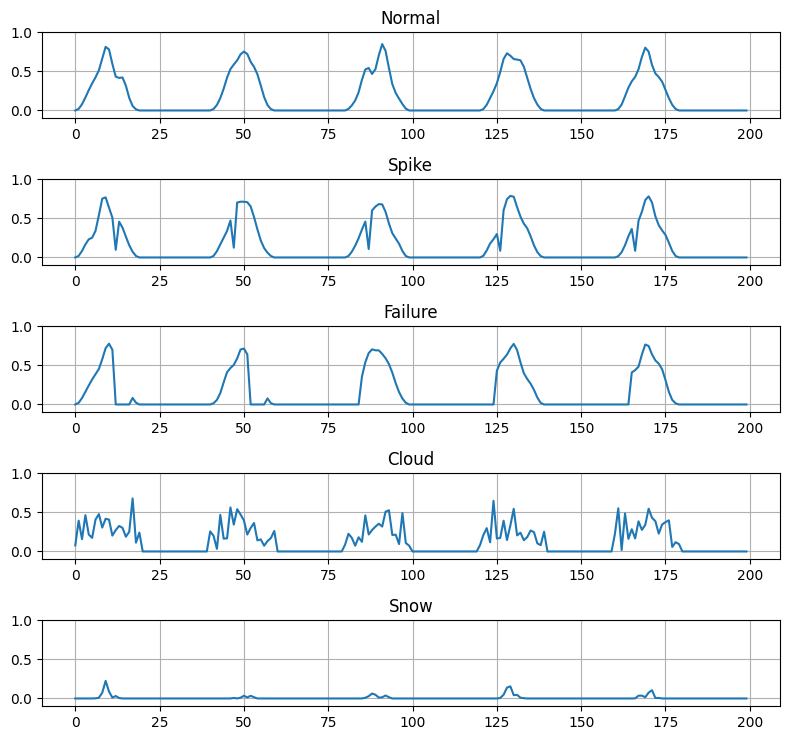

Shape of the normal sample: (32000,)


In [2]:
# Data Generation
n_cycles = 800
n_halfsamples = 20

def generate_normal_data():
    normal_data = np.tile(
        np.hstack([np.hanning(n_halfsamples), np.zeros(n_halfsamples)]),
        n_cycles
    )

    ar1 = np.array([1, -0.9, 0.8])
    ma1 = np.array([1, 1, 1])
    ar = ArmaProcess(ar1, ma1).generate_sample(nsample=len(normal_data))
    normal_data *= np.abs(1 + 0.03 * ar)
    normal_data = minmax(normal_data)

    return normal_data

# Generate normal data
normal_data = generate_normal_data()

# Generate anomalous samples
# Spike anomaly
spike_data = generate_normal_data()
for i in range(n_cycles):
    offset = i * 2 * n_halfsamples + 5 + np.random.randint(n_halfsamples - 10 - 3)
    spike_data[offset:offset+3] *= 1 - 0.8 * np.hanning(3)

# Failure anomaly
failure_data = generate_normal_data()
for i in range(n_cycles):
    offset = i * 2 * n_halfsamples + np.random.randint(n_halfsamples - 5)
    failure_data[offset:offset+5] *= 0

# Cloud anomaly
cloud_data = generate_normal_data()
for i in range(n_cycles):
    offset = i * 2 * n_halfsamples
    cloud_data[offset:offset+n_halfsamples] += np.abs(
        np.random.normal(0, 1, n_halfsamples)
    )
cloud_data = minmax(cloud_data)

# Snow anomaly
snow_data = np.tile(
    np.hstack([
        np.zeros(int(n_halfsamples/2) - 5),
        np.hanning(10),
        np.zeros(int(n_halfsamples/2) - 5),
        np.zeros(n_halfsamples)
    ]),
    n_cycles
)
for i in range(n_cycles):
    offset = i * 2 * n_halfsamples
    snow_data[offset:offset+n_halfsamples] *= np.abs(
        np.random.normal(0, 0.2, n_halfsamples)
    )
snow_data = minmax(snow_data) / 4

# Visualize data patterns
n_plots = 5
fig, ax = plt.subplots(n_plots, 1, figsize=(8, n_plots*1.5))
ax[0].plot(normal_data[:n_halfsamples*10])
ax[0].set_title('Normal')
ax[1].plot(spike_data[:n_halfsamples*10])
ax[1].set_title('Spike')
ax[2].plot(failure_data[:n_halfsamples*10])
ax[2].set_title('Failure')
ax[3].plot(cloud_data[:n_halfsamples*10])
ax[3].set_title('Cloud')
ax[4].plot(snow_data[:n_halfsamples*10])
ax[4].set_title('Snow')

for i in range(n_plots):
    ax[i].grid(True)
    ax[i].set_ylim(-0.1, 1)

plt.tight_layout()
plt.show()

print(f'Shape of the normal sample: {normal_data.shape}')

#constructs composite time-series examples that contain both normal and anomalous segments.


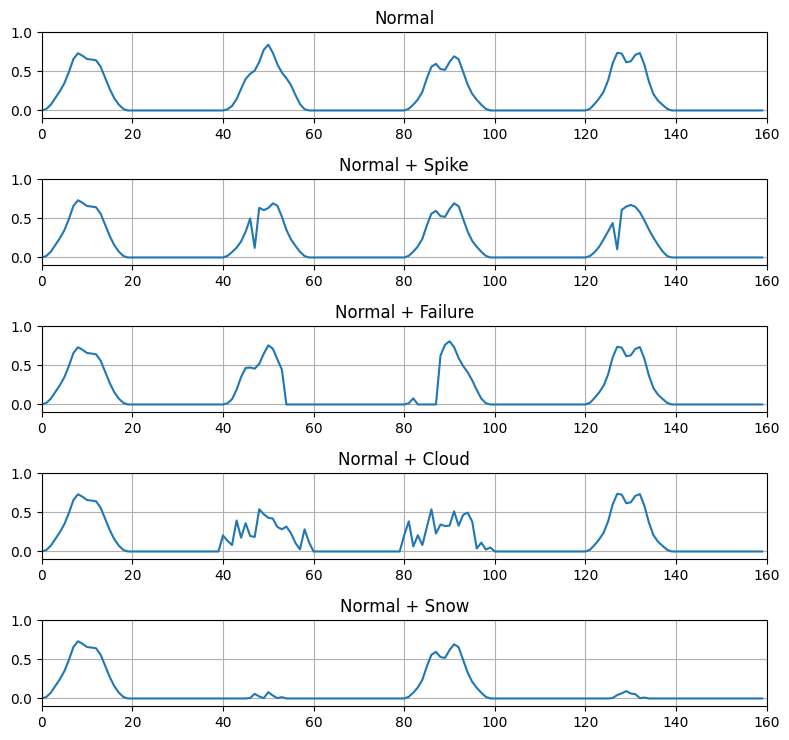

In [3]:
# Create Mixed Examples
n = n_halfsamples * 2

def make_example(nd, ad, mask):
    s = (nd, ad)
    idx = n * np.array([1, 2, 3, 11, 5, 6])

    sample = [s[mask[i]][idx[i]:idx[i]+n] for i in range(6)]
    return np.hstack(sample)

# Create mixed examples
normal_example = make_example(normal_data, normal_data, [0,0,0,0,0,0])
spike_example = make_example(normal_data, spike_data, [0,0,0,1,0,1])
failure_example = make_example(normal_data, failure_data, [0,0,0,1,1,0])
cloud_example = make_example(normal_data, cloud_data, [0,0,0,1,1,0])
snow_example = make_example(normal_data, snow_data, [0,0,0,1,0,1])

# Visualize mixed examples
n_plots = 5
n_window = 80
fig, ax = plt.subplots(n_plots, 1, figsize=(8, n_plots*1.5))

examples = [normal_example, spike_example, failure_example, cloud_example, snow_example]
titles = ['Normal', 'Normal + Spike', 'Normal + Failure', 'Normal + Cloud', 'Normal + Snow']

for i, (example, title) in enumerate(zip(examples, titles)):
    ax[i].plot(example[n_window:])
    ax[i].set_title(title)
    ax[i].grid(True)
    ax[i].set_ylim(-0.1, 1)
    ax[i].set_xlim(0, 160)

plt.tight_layout()
plt.show()

## LSTM Forecasting Dataset Preparation

Prepares the dataset for supervised time-series forecasting.
**Key steps:**
- Sliding window extraction
- Forecast horizon definition
- Train–test split
- Reshaping data into LSTM-compatible format

Only **normal data** is used for training to ensure unsupervised anomaly detection.

In [4]:
# Solution 1 - LSTM Forecasting Model (Preparation)

# Dataset parameters
n_window = 80             # input window
forecast_steps_ahead = 5  # forecasting horizon
train_ratio = 0.8

def samples_supervised(s, n_window, forecast_steps_ahead):
    x, y = [], []
    for i in range(n_window, len(s) - forecast_steps_ahead + 1):
        t_start = i - n_window
        t_end = i

        x_t = s[t_start:t_end]
        y_t = s[t_end + forecast_steps_ahead - 1]

        x.append(x_t)
        y.append(y_t)

    return np.stack(x), np.array(y)

def train_test_split(x, y, train_ratio):
    t = int(len(x) * train_ratio)
    return x[0:t, :], y[0:t], x[t:, :], y[t:]

# Prepare data
x, y = samples_supervised(normal_data, n_window, forecast_steps_ahead)
x_train, y_train, x_test, y_test = train_test_split(x, y, train_ratio)

# Reshape for LSTM (samples, timesteps, features)
x_train = x_train.reshape(x_train.shape[0], n_window, 1)
x_test = x_test.reshape(x_test.shape[0], n_window, 1)

print(f'Train tensor shape: {x_train.shape}')
print(f'Test tensor shape: {x_test.shape}')

Train tensor shape: (25532, 80, 1)
Test tensor shape: (6384, 80, 1)


##LSTM Forecasting Model Training

This defines and trains an LSTM-based forecasting model.

**Model architecture:**
- Single LSTM layer
- Dropout for regularization
- Dense output layer with linear activation

In [5]:
# LSTM Model Training

# Model parameters
hidden_units = 4  # LSTM state dimensionality

# Build model
input_model = layers.Input(shape=(n_window, 1))
layer_lstm = layers.LSTM(hidden_units)(input_model)
layer_dropout = layers.Dropout(rate=0.1)(layer_lstm)
output_dense = layers.Dense(1, activation='linear')(layer_dropout)
model_lstm = models.Model(inputs=input_model, outputs=output_dense)

# Compile and train
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.summary()

history = model_lstm.fit(
    x_train, y_train,
    epochs=10,
    batch_size=4,
    validation_data=(x_test, y_test),
    verbose=1
)

score = model_lstm.evaluate(x_test, y_test, verbose=0)
print(f'\nTest MSE: {score:.6f}')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 80, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 4)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6383/6383 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - loss: 0.0214 - val_loss: 0.0022
Epoch 2/10
6383/6383 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 3/10
6383/6383 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - loss: 0.0043 - val_loss: 0.0027
Epoch 4/10
6383/6383 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.0042 - val_loss: 0.0019
Epoch 5/10
6383/6383 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.0041 - val_loss: 0.0018
Epoch 6/10
6383/6383 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 7/10
6383/6383 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 8/10
6383/6383 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 9/10
6383/6383 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 10/10
6383/6383 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.0037 - val_loss: 0.0020

Test MSE: 0.001997


##LSTM-Based Anomaly Evaluation

This cell evaluates anomaly detection using forecasting errors.

**Detection principle:**
- Compare predicted values with observed values
- Compute squared prediction errors
- Visualize anomalies using heatmaps

Regions with large residuals indicate potential anomalies.

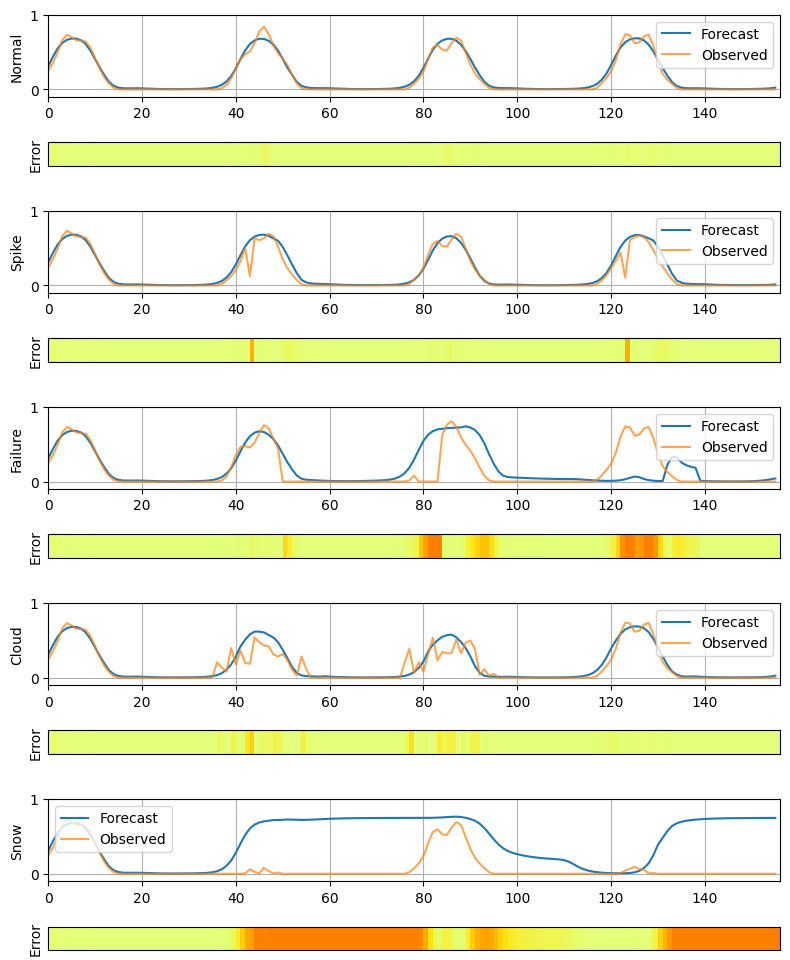

In [6]:
# LSTM Model Evaluation

test_datasets = [normal_example, spike_example, failure_example, cloud_example, snow_example]
titles = ['Normal', 'Spike', 'Failure', 'Cloud', 'Snow']

n_plots = 5
fig, ax = plt.subplots(2*n_plots, 1, figsize=(8, n_plots*2.0))

for i, (d, title) in enumerate(zip(test_datasets, titles)):
    n_forecast = n * 4

    # Prepare data
    x_eval = samples_supervised(d, n_window, forecast_steps_ahead)[0]
    x_eval = x_eval.reshape(x_eval.shape[0], n_window, 1)

    # Get predictions
    y = d[-n_forecast+forecast_steps_ahead-1:]
    y_hat = model_lstm.predict(x_eval, verbose=0).flatten()
    se = np.square(y - y_hat)

    # Plot forecasts
    ax[2*i].plot(y_hat, label='Forecast', linewidth=1.5)
    ax[2*i].plot(y, label='Observed', alpha=0.7, linewidth=1.5)
    ax[2*i].grid(True)
    ax[2*i].legend()
    ax[2*i].set_ylim(-0.1, 1)
    ax[2*i].set_xlim(0, len(y))
    ax[2*i].set_ylabel(title)

    # Plot squared errors as heatmap
    ax[2*i+1].imshow(
        np.atleast_2d(se),
        aspect=5,
        cmap='Wistia',
        vmin=0,
        vmax=0.4
    )
    ax[2*i+1].set_xticks([])
    ax[2*i+1].set_yticks([])
    ax[2*i+1].set_ylabel('Error')

plt.tight_layout()
plt.show()

##Variational Autoencoder (VAE) Class Definition

This cell defines a reusable Variational Autoencoder (VAE) model.

**Core components:**
- Probabilistic latent space using Gaussian distributions
- KL divergence regularization
- Reconstruction loss
- Custom training step implemented with `tf.GradientTape`

The VAE class supports both 1D and 2D inputs.

In [8]:
# Solution 2 - VAE Class Definition

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.enc = keras.Sequential(encoder)
        self.dec = keras.Sequential(decoder)

    def encode(self, x):
        encoded = self.enc(x)
        mu, log_sigma = tf.split(encoded, num_or_size_splits=2, axis=1)
        # Ensure numerical stability
        sigma = tf.exp(log_sigma * 0.5)
        return ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def reconstruct(self, x):
        encoded = self.enc(x)
        mu, _ = tf.split(encoded, num_or_size_splits=2, axis=1)
        return self.decode(mu)

    def decode(self, z):
        return self.dec(z)

    def compute_loss(self, x):
        q_z = self.encode(x)
        z = q_z.sample()
        x_recon = self.decode(z)

        # Prior distribution
        p_z = ds.MultivariateNormalDiag(
            loc=tf.zeros(z.shape[-1]),
            scale_diag=tf.ones(z.shape[-1])
        )

        # KL divergence
        kl_div = ds.kl_divergence(q_z, p_z)
        latent_loss = tf.reduce_mean(tf.maximum(kl_div, 0))

        # Reconstruction loss
        recon_loss = tf.reduce_mean(
            tf.reduce_sum(tf.math.square(x - x_recon), axis=[1, 2])
        )

        return recon_loss + latent_loss

    @tf.function
    def train_step(self, x):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return loss

##Variational Autoencoder (VAE) Class Definition

This defines a reusable Variational Autoencoder (VAE) model.

**Core components:**
- Probabilistic latent space using Gaussian distributions
- KL divergence regularization
- Reconstruction loss
- Custom training step implemented with `tf.GradientTape`

The VAE class supports both 1D and 2D inputs.

In [9]:
# VAE Data Preparation

# Dataset parameters
n_window = 80
train_ratio = 0.8

def samples_unsupervised(s, n_window):
    x = []
    for i in range(n_window, len(s)):
        x.append(s[i - n_window:i])
    return np.stack(x)

def train_test_split_unsupervised(x, train_ratio):
    t = int(len(x) * train_ratio)
    return x[0:t, :], x[t:, :]

# Prepare dataset
x = samples_unsupervised(normal_data, n_window)
x_train, x_test = train_test_split_unsupervised(x, train_ratio)

print(f'Train tensor shape: {x_train.shape}')
print(f'Test tensor shape: {x_test.shape}')

# Model parameters
n_z = 2  # embedding dimensionality

# Define encoder
encoder = [
    layers.InputLayer(input_shape=(n_window, 1)),
    layers.Conv1D(filters=4, kernel_size=3, activation="relu"),
    layers.Conv1D(filters=8, kernel_size=3, activation="relu"),
    layers.Flatten(),
    layers.Dropout(rate=0.1),
    layers.Dense(units=n_z*2),
]

# Define decoder
decoder = [
    layers.Dense(units=20 * 8, activation="relu"),
    layers.Reshape(target_shape=(20, 8)),
    layers.Conv1DTranspose(
        filters=8, kernel_size=3, strides=2, padding="SAME", activation="relu"
    ),
    layers.Conv1DTranspose(
        filters=4, kernel_size=3, strides=2, padding="SAME", activation="relu"
    ),
    layers.Conv1DTranspose(
        filters=1, kernel_size=3, strides=1, padding="SAME", activation="linear"
    ),
]

# Prepare training dataset
TRAIN_BUF = 60000
BATCH_SIZE = 512
train_samples = x_train.reshape(x_train.shape[0], n_window, 1).astype("float32")
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_samples)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)

print(f'Training batches: {len(list(train_dataset))}')

Train tensor shape: (25536, 80)
Test tensor shape: (6384, 80)
Training batches: 50


##VAE Training (Time Domain)

 Training the time-domain VAE model.

**Training setup:**
- Adam optimizer
- Low-dimensional latent space
- Multiple training epochs with loss monitoring

The VAE learns a compact representation of normal signal patterns.

In [10]:
# VAE Model Training

# Create and compile model
optimizer = keras.optimizers.Adam(1e-3)
model_vae = VAE(encoder=encoder, decoder=decoder)
model_vae.optimizer = optimizer

# Training loop
n_epochs = 100
print("Training VAE...")

for epoch in range(n_epochs):
    epoch_loss = []
    for train_x in train_dataset:
        loss = model_vae.train_step(train_x)
        epoch_loss.append(loss.numpy())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {np.mean(epoch_loss):.4f}')

print("Training complete!")

Training VAE...
Epoch 10/100, Loss: 2.9543
Epoch 20/100, Loss: 2.8440
Epoch 30/100, Loss: 2.8224
Epoch 40/100, Loss: 2.8084
Epoch 50/100, Loss: 2.8012
Epoch 60/100, Loss: 2.7844
Epoch 70/100, Loss: 2.7780
Epoch 80/100, Loss: 2.7901
Epoch 90/100, Loss: 2.7693
Epoch 100/100, Loss: 2.7812
Training complete!


##VAE Evaluation (Time Domain)

Evaluation of anomaly detection using reconstruction error.

**Process:**
- Reconstruct input sequences
- Compute squared reconstruction error at a reference time position
- Visualize reconstruction quality and error heatmaps

Anomalies appear as spikes in reconstruction error.

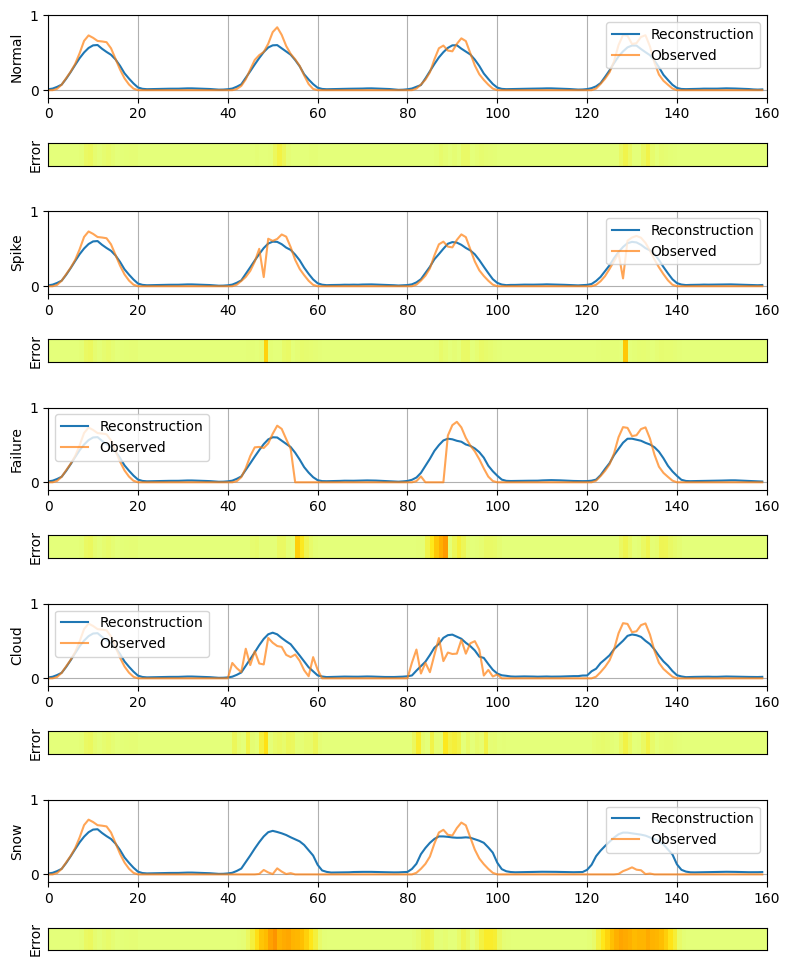

In [11]:
# VAE Model Evaluation

test_datasets = [normal_example, spike_example, failure_example, cloud_example, snow_example]
titles = ['Normal', 'Spike', 'Failure', 'Cloud', 'Snow']

n_plots = 5
fig, ax = plt.subplots(2*n_plots, 1, figsize=(8, n_plots*2.0))

for i, (d, title) in enumerate(zip(test_datasets, titles)):
    # Prepare data
    x_eval = samples_unsupervised(d, n_window)
    x_eval_3d = x_eval.reshape(x_eval.shape[0], n_window, 1).astype("float32")

    # Get reconstructions
    x_hat = model_vae.reconstruct(x_eval_3d).numpy()[:, :, 0]

    # Calculate reconstruction error at middle position
    pos = n_window - 1
    se = np.square(x_eval - x_hat)[:, pos]

    # Plot reconstructions
    ax[2*i].plot(x_hat[:, pos], label='Reconstruction', linewidth=1.5)
    ax[2*i].plot(x_eval[:, pos], label='Observed', alpha=0.7, linewidth=1.5)
    ax[2*i].grid(True)
    ax[2*i].legend()
    ax[2*i].set_ylim(-0.1, 1)
    ax[2*i].set_xlim(0, len(x_eval))
    ax[2*i].set_ylabel(title)

    # Plot reconstruction error as heatmap
    ax[2*i+1].imshow(
        np.atleast_2d(se),
        aspect=5,
        cmap='Wistia',
        vmin=0,
        vmax=0.4
    )
    ax[2*i+1].set_xticks([])
    ax[2*i+1].set_yticks([])
    ax[2*i+1].set_ylabel('Error')

plt.tight_layout()
plt.show()

Frequency Domain Transformation (STFT)

This transforms time-series signals into the frequency domain using the Short-Time Fourier Transform (STFT).

**Motivation:**
- Certain anomalies are more detectable in spectral representations
- Captures time–frequency characteristics of machine behavior

Spectrograms are generated and visualized for all datasets

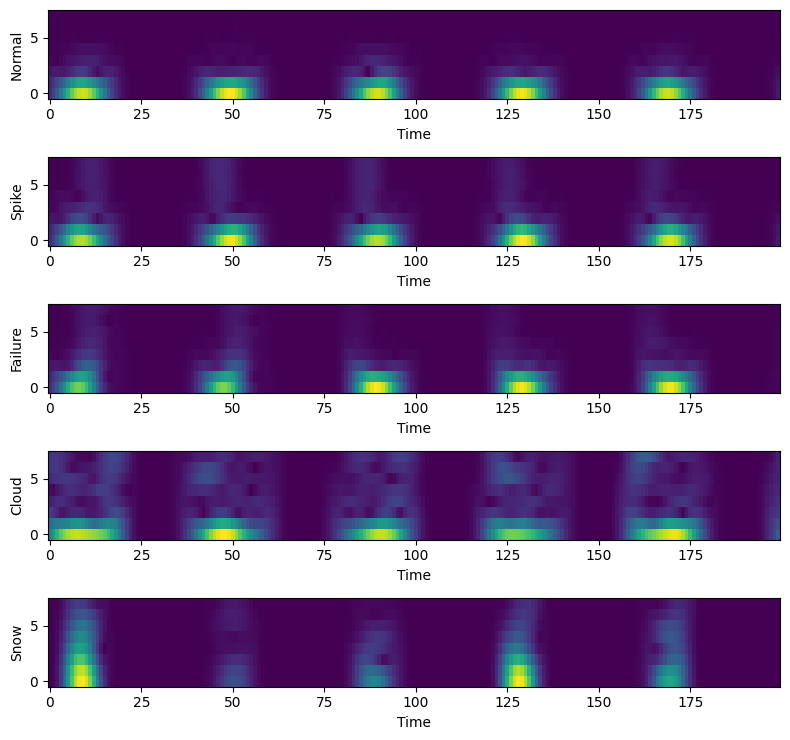

Spectrogram shape: (8, 32000)


In [12]:
# Solution 3 - Frequency Domain Transformation

# Map time series to spectral domain using STFT
def stft(x):
    _, _, Zxx = signal.stft(x, 1, nperseg=15, noverlap=14)
    return np.abs(Zxx)

# Transform all datasets
normal_data_fq = stft(normal_data)
spike_data_fq = stft(spike_data)
failure_data_fq = stft(failure_data)
cloud_data_fq = stft(cloud_data)
snow_data_fq = stft(snow_data)

# Visualize spectrograms
train_datasets_fq = [
    normal_data_fq, spike_data_fq, failure_data_fq,
    cloud_data_fq, snow_data_fq
]
titles = ['Normal', 'Spike', 'Failure', 'Cloud', 'Snow']

n_plots = 5
fig, ax = plt.subplots(n_plots, 1, figsize=(8, n_plots*1.5))

for i, (d, title) in enumerate(zip(train_datasets_fq, titles)):
    ax[i].imshow(
        d[:, :n_halfsamples*10],
        aspect='auto',
        cmap='viridis',
        origin='lower'
    )
    ax[i].set_ylabel(title)
    ax[i].set_xlabel('Time')

plt.tight_layout()
plt.show()

print(f'Spectrogram shape: {normal_data_fq.shape}')

##2D VAE Preparation (Frequency Domain)

This prepares spectrogram windows for training a 2D convolutional VAE.

**Key ideas:**
- Each sample represents a time–frequency patch
- Enables learning of spatial correlations in the spectral domain
- Data reshaped into 4D tensors for Conv2D layers

In [13]:
#2D VAE Preparation for Frequency Domain

# Dataset parameters
n_window = 80
train_ratio = 0.8
n_frequencies = normal_data_fq.shape[0]

def samples_unsupervised_2d(s, n_window):
    x = []
    for i in range(n_window, s.shape[1]):
        x.append(s[:, i - n_window:i])
    return np.stack(x)

# Prepare dataset
x = samples_unsupervised_2d(normal_data_fq, n_window)
x_train, x_test = train_test_split_unsupervised(x, train_ratio)

print(f'Train tensor shape: {x_train.shape}')
print(f'Test tensor shape: {x_test.shape}')

# Model parameters
n_z = 8  # embedding dimensionality

# Define 2D encoder
encoder_2d = [
    layers.InputLayer(input_shape=(n_frequencies, n_window, 1)),
    layers.Conv2D(filters=8, kernel_size=3, strides=(2, 2), activation="relu"),
    layers.Conv2D(filters=16, kernel_size=3, strides=(2, 2), activation="relu"),
    layers.Flatten(),
    layers.Dropout(rate=0.1),
    layers.Dense(units=n_z*2),
]

# Define 2D decoder
decoder_2d = [
    layers.Dense(units=2 * 20 * 8, activation="relu"),
    layers.Reshape(target_shape=(2, 20, 8)),
    layers.Conv2DTranspose(
        filters=16, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    layers.Conv2DTranspose(
        filters=8, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="linear"
    ),
]

# Prepare training dataset
TRAIN_BUF = 60000
BATCH_SIZE = 512
train_samples = x_train.reshape(
    x_train.shape[0], n_frequencies, n_window, 1
).astype("float32")
train_dataset_2d = (
    tf.data.Dataset.from_tensor_slices(train_samples)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)

print(f'Training batches: {len(list(train_dataset_2d))}')

Train tensor shape: (25536, 8, 80)
Test tensor shape: (6384, 8, 80)
Training batches: 50


##2D VAE Training (Frequency Domain)

This trains a convolutional VAE on normal spectrogram data.

**Model characteristics:**
- Conv2D encoder and decoder
- Higher-dimensional latent space
- Captures structured spectral patterns

In [14]:
# 2D VAE Model Training

# Create and compile model
optimizer = keras.optimizers.Adam(1e-3)
model_vae_2d = VAE(encoder=encoder_2d, decoder=decoder_2d)
model_vae_2d.optimizer = optimizer

# Training loop
n_epochs = 100
print("Training 2D VAE...")

for epoch in range(n_epochs):
    epoch_loss = []
    for train_x in train_dataset_2d:
        loss = model_vae_2d.train_step(train_x)
        epoch_loss.append(loss.numpy())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {np.mean(epoch_loss):.4f}')

print("Training complete!")

Training 2D VAE...
Epoch 10/100, Loss: 2.6373
Epoch 20/100, Loss: 2.5658
Epoch 30/100, Loss: 2.5675
Epoch 40/100, Loss: 2.5506
Epoch 50/100, Loss: 2.5606
Epoch 60/100, Loss: 2.5467
Epoch 70/100, Loss: 2.5390
Epoch 80/100, Loss: 2.5544
Epoch 90/100, Loss: 2.5592
Epoch 100/100, Loss: 2.5497
Training complete!


##2D VAE Evaluation and Visualization

This cell evaluates anomaly detection in the frequency domain.

**Visualization modes:**
- Spectrogram reconstruction
- Spectral anomaly heatmaps

Anomalies manifest as deviations in reconstructed spectral energy over time.

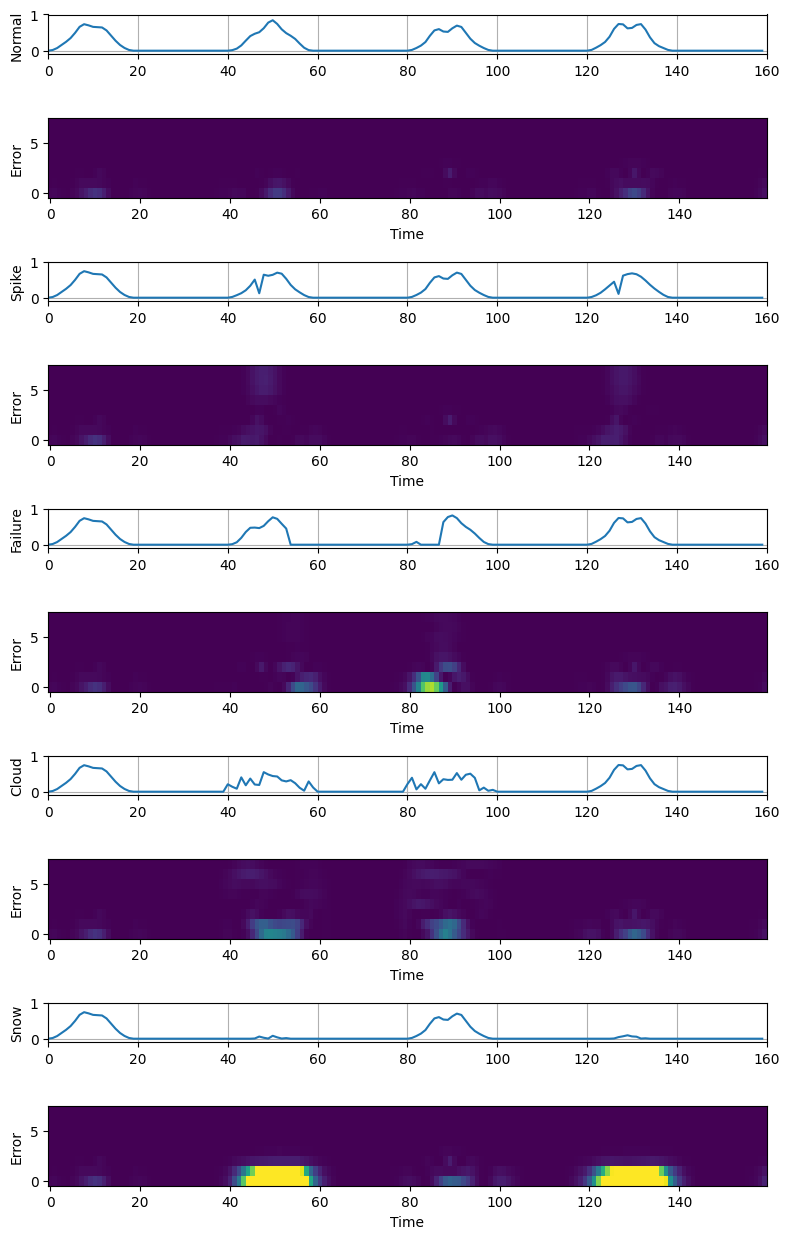

In [15]:
# 2D VAE Model Evaluation

test_datasets = [normal_example, spike_example, failure_example, cloud_example, snow_example]
titles = ['Normal', 'Spike', 'Failure', 'Cloud', 'Snow']

# Choose visualization mode
mode = 'anomaly'  # Options: 'spectrogram' or 'anomaly'

n_plots = 5
fig, ax = plt.subplots(
    2*n_plots, 1,
    figsize=(8, n_plots*2.5),
    gridspec_kw={'height_ratios': np.tile([1, 2], n_plots)}
)

for i, (d, title) in enumerate(zip(test_datasets, titles)):
    # Transform to frequency domain
    d_fq = stft(d)

    # Prepare data
    x_eval = samples_unsupervised_2d(d_fq, n_window)
    x_eval_4d = np.expand_dims(x_eval, axis=3).astype("float32")

    # Get reconstructions
    x_hat = model_vae_2d.reconstruct(x_eval_4d).numpy()[:, :, :, 0]

    # Calculate reconstruction error at middle position
    pos = n_window - 1
    se = np.square(x_eval - x_hat)[:, :, pos]

    # Plot time series
    ax[2*i].plot(d[n_window:])
    ax[2*i].set_ylim(-0.1, 1)
    ax[2*i].set_xlim(0, len(d) - n_window)
    ax[2*i].grid(True)
    ax[2*i].set_ylabel(title)

    # Plot spectrogram or anomaly score
    if mode == 'spectrogram':
        ax[2*i+1].imshow(
            x_eval[:, :, pos].T,
            aspect='auto',
            cmap='viridis',
            vmin=0,
            vmax=0.2,
            origin='lower'
        )
        ax[2*i+1].set_ylabel('Frequency')
    elif mode == 'anomaly':
        ax[2*i+1].imshow(
            se.T,
            aspect='auto',
            cmap='viridis',
            vmin=0,
            vmax=0.05,
            origin='lower'
        )
        ax[2*i+1].set_ylabel('Error')

    ax[2*i+1].set_xlabel('Time')

plt.tight_layout()
plt.show()

Current Status and Future Work

- ✔ Functional anomaly detection prototype
- ✔ Multiple modeling approaches implemented
- ✔ Suitable for experimentation and research extension

**Planned improvements:**
- Automatic anomaly thresholding
- Quantitative evaluation metrics
- Hyperparameter tuning